## Tranformer for stock prediction

### Setting model parameter

In [1]:
import pandas as pd
from datetime import datetime
EPOCHS = 100
BATCH_SIZE = 32
TIME_STEPS = 32
KEY_DIM = 128
VALUE_DIM = 128
N_HEAD = 8
FF_DIM = 128
MEAN = 10
PTC = True
STOCK_TICKER = 'IBM' # Ticker of company
STOCK_START_DATE = pd.to_datetime('2005-01-01')     # Train data from start date to validation date
STOCK_END_DATE = pd.to_datetime('2022-01-04')
STOCK_VALIDATION_PER = 0.2
CHECKPOINT_FOLDER = "./checkpoint/tranformer"

### Read data and split data to train and test

In [2]:
import yfinance as yf
print("Train Data From: " + STOCK_START_DATE.strftime("%Y-%m-%d"), end=" ")
print('To: ' + STOCK_END_DATE.strftime("%Y-%m-%d"))
df = yf.download([STOCK_TICKER], start=STOCK_START_DATE, end=STOCK_END_DATE)
df.head()

Train Data From: 2005-01-01 To: 2022-01-04
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-31,94.263863,94.560226,94.158699,94.244743,57.603477,2921687
2005-01-03,94.617592,94.741875,92.973228,93.451241,57.118458,5538779
2005-01-04,93.441681,94.091782,92.275337,92.447418,56.504917,5973706
2005-01-05,92.351814,93.527725,92.160614,92.256210,56.388050,5906448
2005-01-06,92.294456,92.715103,91.826004,91.969406,56.212757,4771538


### Moving Average closing price

<AxesSubplot:title={'center':'Mean Close Price'}, xlabel='Date'>

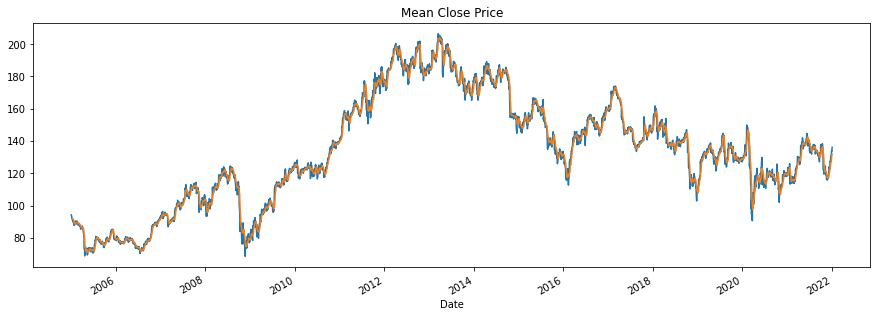

In [3]:
import matplotlib.pyplot as plt
df_mean = df.copy()
if MEAN > 1:
# Apply moving average with a window of MEAN days to all columns
    df_mean[['Close']] = df[['Close']].rolling(MEAN).mean() 
    # Drop all rows with NaN values
    df_mean.dropna(how='any', axis=0, inplace=True)
plt.figure(figsize=(15, 5))
df['Close'].plot(title="Close Price")
df_mean['Close'].plot(title="Mean Close Price")

### Calculate percentage change for all columns

In [4]:
if PTC:
    df_mean['Close'] = df_mean['Close'].pct_change()
    df_mean.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

### Data distribution

<AxesSubplot:xlabel='Close', ylabel='Count'>

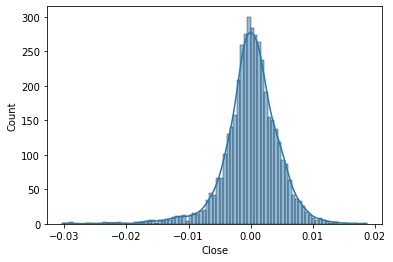

In [5]:
import seaborn as sns
sns.histplot(df_mean['Close'], kde=True)

### Split data

In [6]:
times = sorted(df_mean.index.values)
greater_train_index = times[-int(STOCK_VALIDATION_PER*len(times))]
df_train = df_mean[df_mean.index < greater_train_index].copy()
df_val = df_mean[df_mean.index >= greater_train_index].copy()

print('Training data shape: {}'.format(df_train.shape))
print('Validation data shape: {}'.format(df_val.shape))

Training data shape: (3418, 6)
Validation data shape: (854, 6)


### Plot daily changes of close prices and volume

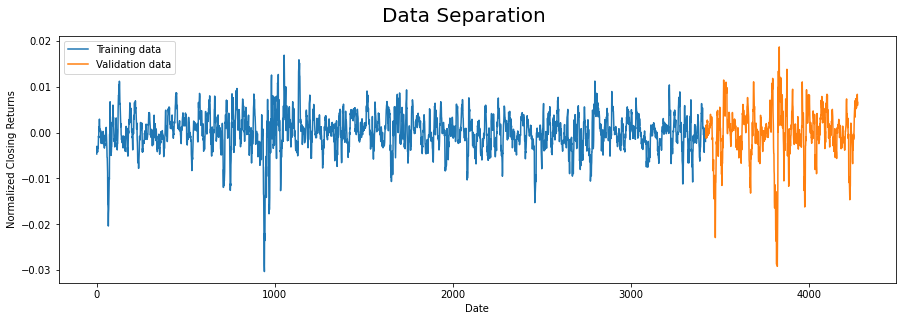

In [7]:
import numpy as np
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(df_train.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(df_train.shape[0], 
                   df_train.shape[0]+df_val.shape[0]), df_val['Close'], label='Validation data')

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')


plt.legend(loc='best')

### Normalization

In [8]:
from sklearn.preprocessing import MinMaxScaler
'''Normalize price columns'''
min_max = MinMaxScaler()
min_max.fit(df_mean[['Close']])
train_scaled = min_max.transform(df_train[['Close']])
val_scaled = min_max.transform(df_val[['Close']])

### Create data label by time sequence

In [9]:
import data
# Serialize data and generate labels for train data
x_train, y_train = data.create_data_label(train_scaled, TIME_STEPS)
x_validation, y_validation = data.create_data_label(val_scaled, TIME_STEPS)
print('Shape Of X_Train Data :')
print(x_train.shape)
print('Shape of X_Validation Data :')
print(x_validation.shape)

Shape Of X_Train Data :
(3386, 32, 1)
Shape of X_Validation Data :
(822, 32, 1)


### TimeVector Model

In [10]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow as tf

class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
        
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)



### Transformer model

In [11]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k,
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out

#############################################################################


class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
        self.linear = Dense(input_shape[0][-1],
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

#############################################################################


class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(
            input_shape=input_shape, epsilon=1e-6)

        self.ff_net = Sequential([
            tf.keras.layers.Dense(self.ff_dim, activation='relu'),
            tf.keras.layers.Dense(input_shape[0][-1])
        ])
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(
            input_shape=input_shape, epsilon=1e-6)

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_net(attn_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer


### Create Model

In [12]:
# from tensorflow.keras.utils import plot_model
def create_model():
    time_embedding = Time2Vector(TIME_STEPS)
    attn_layer1 = TransformerEncoder(KEY_DIM, VALUE_DIM, N_HEAD, FF_DIM)
    attn_layer2 = TransformerEncoder(KEY_DIM, VALUE_DIM, N_HEAD, FF_DIM)
    attn_layer3 = TransformerEncoder(KEY_DIM, VALUE_DIM, N_HEAD, FF_DIM)

    '''Construct model'''
    in_seq = Input(shape=(TIME_STEPS, 1))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model


model = create_model()
model.summary()
# plot_model(model, to_file='./img/model_tranformer.png', show_shapes=True,
#                               show_layer_names=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 1)]      0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 32, 2)        128         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 32, 3)        0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 32, 3)       16274       ['concatenate[0][0]',        

### Train model

In [13]:
import tensorflow as tf
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_validation, y_validation),
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)])
model.save(CHECKPOINT_FOLDER)
#Print evaluation metrics for all datasets
train_eval = model.evaluate(x_train, y_train, verbose=0)
val_eval = model.evaluate(x_validation, y_validation, verbose=0)
print('Training Data - Loss: {:.4f}, MAE: {:.4f}'.format(train_eval[0], train_eval[1]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}'.format(val_eval[0], val_eval[1]))

Epoch 1/100
 42/106 [==========>...................] - ETA: 7s - loss: 0.1483 - mae: 0.3206 - mape: 51.5181

KeyboardInterrupt: 

### Visualize loss by epochs

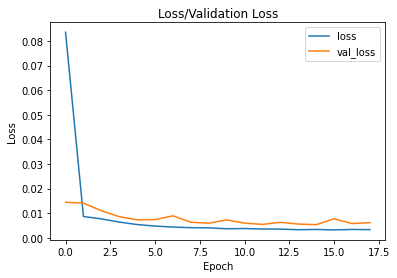

In [ ]:
import visualize
visualize.visualize_loss(history)

### Set data to test

Test Data From: 2017-01-01 End Date: 2022-02-11
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Close Price'}, xlabel='Date'>

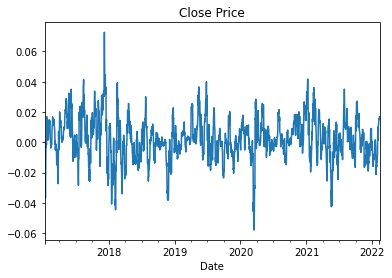

In [ ]:
import pandas as pd
TEST_TICKER = 'BTC-USD'
STOCK_TEST_DATE = pd.to_datetime('2017-01-01') # Test data from this to now
import yfinance as yf
from datetime import datetime
print("Test Data From: " + STOCK_TEST_DATE.strftime("%Y-%m-%d"), end=" ")
end_date = datetime.today()
print('End Date: ' + end_date.strftime("%Y-%m-%d"))
test_data = yf.download([TEST_TICKER], start=STOCK_TEST_DATE, end=end_date)
if MEAN > 1:
    test_data[['Close']] = test_data[['Close']].rolling(MEAN).mean()
    test_data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
if PTC:
    test_data['Close'] = test_data['Close'].pct_change()
    test_data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
test_data['Close'].plot(title="Close Price")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
'''Normalize price columns'''
min_max_test = MinMaxScaler()
min_max_test.fit(test_data[['Close']])
test_scaled = min_max_test.transform(test_data[['Close']])

import data
# Serialize data and generate labels for train data
x_test, y_test = data.create_data_label(test_scaled, TIME_STEPS)
print('Shape Of X_Test Data :')
print(x_test.shape)

Shape Of X_Test Data :
(1826, 32, 1)


In [ ]:
import visualize
import tensorflow as tf
model = tf.keras.models.load_model(CHECKPOINT_FOLDER)
test_predictions = model.predict(x_test)
print("predict shape")
print(test_predictions.shape)
# visualize.visualize_predict(y_test,
#     test_predictions, model_name="LSTM")
test_eval = model.evaluate(x_test, y_test, verbose=0)
print('Test Data - Loss: {:.4f}, MSE: {:.4f}'.format(test_eval[0], test_eval[1]))

predict shape
(1826, 1)
Test Data - Loss: 0.0113, MSE: 0.0933


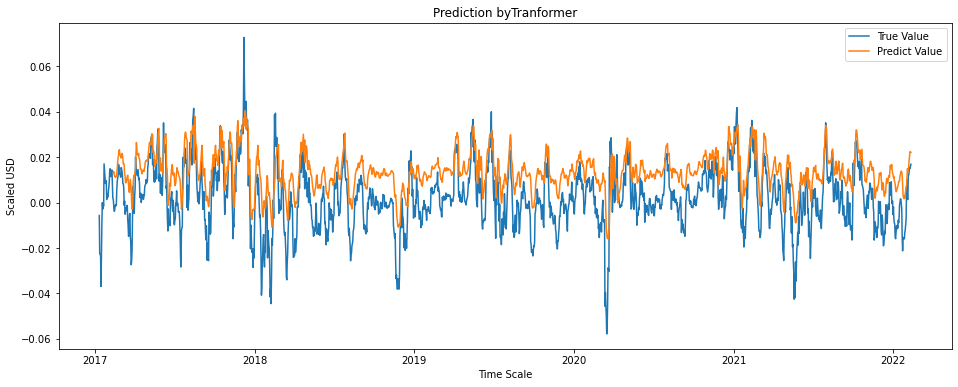

In [ ]:
test_predictions = min_max_test.inverse_transform(test_predictions)
test_predictions = pd.DataFrame(test_predictions)
test_predictions.rename(
    columns={0: TEST_TICKER + '_predicted'}, inplace=True)
# test_predictions = test_predictions.round(decimals=0)
test_predictions.index = test_data[TIME_STEPS:].index
visualize.visualize_predict(test_data['Close'],
    test_predictions, model_name="Tranformer")

In [ ]:
print(test_predictions[-20:])
print(test_data['Close'][-20:])

            BTC-USD_predicted
Date                         
2022-01-22           0.007592
2022-01-23           0.003435
2022-01-24           0.002085
2022-01-25           0.001713
2022-01-26           0.003055
2022-01-27           0.001792
2022-01-28           0.004022
2022-01-29           0.005175
2022-01-30           0.007022
2022-01-31           0.007533
2022-02-01           0.011547
2022-02-02           0.014925
2022-02-03           0.014247
2022-02-04           0.013463
2022-02-05           0.016313
2022-02-06           0.018924
2022-02-07           0.020898
2022-02-08           0.022428
2022-02-09           0.022287
2022-02-10           0.022099
Date
2022-01-22   -0.021264
2022-01-23   -0.015382
2022-01-24   -0.015946
2022-01-25   -0.015646
2022-01-26   -0.015993
2022-01-27   -0.013269
2022-01-28   -0.012077
2022-01-29   -0.009602
2022-01-30   -0.007428
2022-01-31    0.005487
2022-02-01    0.010002
2022-02-02    0.001803
2022-02-03    0.001332
2022-02-04    0.012089
2022-02-05   